# Отток клиентов

Имеются исторические ланные о поведении клиентов банка. Необходимо спрогновировать уйдетли клиент или нет 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Общее

## Описание данных

### Признаки

1. `RowNumber` — индекс строки в данных
2. `CustomerId` — уникальный идентификатор клиента
3. `Surname` — фамилия
4. `CreditScore` — кредитный рейтинг
5. `Geography` — страна проживания
6. `Gender` — пол
7. `Age` — возраст
8. `Tenure` — количество недвижимости у клиента
9. `Balance` — баланс на счёте
10. `NumOfProducts` — количество продуктов банка, используемых клиентом
11. `HasCrCard` — наличие кредитной карты
12. `IsActiveMember` — активность клиента
13. `EstimatedSalary` — предполагаемая зарплата

### Целевой признак

1. `Exited` — факт ухода клиента

## Импортируем библиотеки

In [1]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# Для работы со статистикой
from scipy import stats as st

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

# Для Графиков
import matplotlib.pyplot as plt
import seaborn as sns

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#для построения моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn import tree


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle


from sklearn.preprocessing import StandardScaler

import joblib

## Используемые функции

Функция поиска выбросов

In [2]:
def find_outlines (column, board=1.5):
    """
    Функция возвращает границы выбросов
    """
    q1   = np.percentile(column, 25)
    q3   = np.percentile(column, 75)
    iqr  = q3 - q1
    low  = q1 - board * iqr
    high = q3 + board * iqr
    return low, high

Построение графика распределения бинарного признака

In [3]:
def count_features_plot(column, plot_width=8, plot_heigth=6):
    fig, ax = plt.subplots()
    fig.set_size_inches(plot_width, plot_heigth)

    sns.countplot(x=column,
                  ax=ax,
                  palette="deep"
                 )

    ax.set_xlabel('Значение признака', fontsize=14)
    ax.set_ylabel('Количество наблюдений', fontsize=14)
    plt.title('Распределение признака\n', fontsize=18)

    plt.xticks(size=11)
    plt.yticks(size=11)

    plt.show()

Добавление в результирующую таблицу

In [5]:
def add_to_result_table(model_name, res, conf_matr):
    res["model_name"].append(model_name)
    res["TN"].append(conf_matr[0,0])
    res["TP"].append(conf_matr[1,1])
    res["FP"].append(conf_matr[0,1])
    res["FN"].append(conf_matr[1,0])
    
    df = pd.DataFrame(res)
    df['Recall'] = df['TP'] / (df['TP'] + df['FN'])
    df['Percision'] = df['TP'] / (df['TP'] + df['FP'])
    df['F1_score'] = 2 * df['Recall'] * df['Percision'] /(df['Percision'] + df['Recall'])
    
    return df, res

Обучение и проверка качества модели

In [6]:
def model_fit_and_chek(model, X_tr, y_tr, X_val, y_val):
    model.fit(X_tr, y_tr)
    prediction = model.predict(X_val)
    print('Accuracy : {:.4f}'.format(accuracy_score(y_val, prediction)))
    print('F1 метрика: {:.4f}'.format(f1_score(y_val, prediction)))
    
    sanity_check = pd.Series([0 for i in range(len(y_val))])
    print('Sanity check accuracy: {:.4f}'.format(accuracy_score(y_val, sanity_check)))
    
    sns.heatmap(confusion_matrix(y_val, prediction), annot=True, fmt='d', linewidths=.8)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()
    return prediction, f1_score(y_val, prediction), confusion_matrix(y_val, prediction)


Построение PR-кривой

In [7]:
def PR_curve_building(model, X_val, y_val):   
    probabilities_valid = model.predict_proba(X_val)
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities_valid[:, 1])

    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show()

Построение ROC кривой и расчет AUC

In [8]:
def ROC_curve_building(model, X_val, y_val): 
    probabilities_valid = model.predict_proba(X_val)
    fpr, tpr, thresholds = roc_curve(y_val, probabilities_valid[:, 1])
    plt.figure()

    plt.step(fpr, tpr)

    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')

    plt.show()
    
    auc_roc_model = roc_auc_score(y_val, probabilities_valid[:, 1])
    print('AUC-ROC score: {:.4f}'.format(auc_roc_model))
    
    return probabilities_valid, auc_roc_model

Подбор гипперпараметров для Логистической Регрессии

In [9]:
def hiperparam_for_LogReg(X_tr, y_tr,
                          X_val, y_val, cl_wigth=None,
                          chek_range=np.logspace(-6, 1, num = 40) 
                         ):
    """
    Подбор гипперпараметров для Логистической Регрессии
    """
    lr_model_param = {
        "f1_score" : 0,
        "c_value"  : 0
    }

    c_value = []
    f1_list = []

    for c_val in chek_range:
        model = LogisticRegression(C=c_val, random_state=0, solver='liblinear', class_weight=cl_wigth)
        model.fit(X_tr, y_tr)
        predict_lr = model.predict(X_val)
        f1_lr_model = f1_score(y_val, predict_lr)
        c_value.append(c_val)
        f1_list.append(f1_lr_model)
        
        if f1_lr_model > lr_model_param["f1_score"]:
            lr_model_param["f1_score"] = f1_lr_model
            lr_model_param["c_value"] = c_val
            
    model = LogisticRegression(C=lr_model_param["c_value"],
                               random_state=0, solver='liblinear',
                               class_weight=cl_wigth
                              )
    print('\nЛучший результат f1_score = {:.5f} при:'.format(lr_model_param['f1_score']))
    print('C_value = {:.5f}'.format(lr_model_param['c_value']))
    
    return model, lr_model_param,  c_value, f1_list

Подбор гипперпараметров для Дерева решений

In [10]:
def hiperparam_for_DecTree (param, X_tr, y_tr,
                          X_val, y_val, cl_wigth=None
                          ):
    """
    Подбор гипперпараметров для Дерева решений
    
    """
    best_score_dtc = {
        'f1_score'          : 0,
        'max_depth'         : 0,
        'min_samples_split' : 0,
        'min_samples_leaf'  : 0,
        'random_state'      : 12345
    }
    
    iter_number = []
    f1_dtc_list = []
    count = 1

    for depth in param['max_depth']:
        for min_split in param['min_samples_split']:
            for min_leaf in param['min_samples_leaf']:
                model_dtc = DecisionTreeClassifier(random_state=12345,
                                                    max_depth=depth, min_samples_split=min_split,
                                                    min_samples_leaf=min_leaf, class_weight=cl_wigth)
                model_dtc.fit(X_tr, y_tr)

                prediction_dtc = model_dtc.predict(X_val)
                f1_score_dtc = f1_score(y_val, prediction_dtc)

                if f1_score_dtc > best_score_dtc['f1_score']:
                    best_score_dtc['f1_score']  = f1_score_dtc
                    best_score_dtc['max_depth'] = depth
                    best_score_dtc['min_samples_split'] = min_split
                    best_score_dtc['min_samples_leaf'] = min_leaf
                    
                iter_number.append(count)
                f1_dtc_list.append(f1_score_dtc)
                count += 1
                
    model_dtc = DecisionTreeClassifier(random_state=best_score_dtc['random_state'],
                                       max_depth=best_score_dtc['max_depth'],
                                       min_samples_split=best_score_dtc['min_samples_split'],
                                       min_samples_leaf=best_score_dtc['min_samples_leaf'],
                                       class_weight=cl_wigth
                                      )
    
    print('\nЛучший результат f1_score = {:.5f} при:'.format(best_score_dtc['f1_score']))
    print('\tmax_depth = {:.0f}'.format(best_score_dtc['max_depth']))
    print('\tmin_samples_split = {:.0f}'.format(best_score_dtc['min_samples_split']))
    print('\tmin_samples_leaf = {:.0f}'.format(best_score_dtc['min_samples_leaf']))
    
    return model_dtc, best_score_dtc, iter_number, f1_dtc_list

Подбор гипперпараметров для Случайного леса

In [11]:
def hiperparam_for_RandForest (param, X_tr, y_tr,
                          X_val, y_val, cl_wigth=None
                          ):
    """
    Подбор гипперпараметров для Дерева решений
    """
    best_score_rfc = {
        'f1_score'          : 0,
        'random_state'      : 12345,
        'n_estimators'      : 0,
        'max_features'      : 0,
        'max_depth'         : 0,
        'min_samples_leaf'  : 0,
        'bootstrap'         : 0,

    }

    iter_number = []
    f1_rfc_list = []
    count = 1

    for n_estim in param['n_estimators']:
        for features in param['max_features']:
            for depth in param['max_depth']:
                for min_leaf in param['min_samples_leaf']:              
                    for boot_strap in param['bootstrap']:

                        model_rfc = RandomForestClassifier(random_state=12345,
                                                            n_estimators=n_estim,
                                                            max_features=features,
                                                            max_depth=depth,
                                                            min_samples_split=2,
                                                            min_samples_leaf=min_leaf,
                                                            bootstrap=boot_strap,
                                                            criterion='gini',
                                                            class_weight=cl_wigth
                                                           )
                        model_rfc.fit(X_tr, y_tr)

                        predict_rfc = model_rfc.predict(X_val)
                        f1_score_rfc = f1_score(y_val, predict_rfc)

                        if f1_score_rfc > best_score_rfc['f1_score']:
                            best_score_rfc['f1_score']  = f1_score_rfc
                            best_score_rfc['max_features']  = features
                            best_score_rfc['n_estimators'] = n_estim
                            best_score_rfc['max_depth'] = depth
                            best_score_rfc['min_samples_leaf'] = min_leaf
                            best_score_rfc['bootstrap'] = boot_strap

                        iter_number.append(count)
                        f1_rfc_list.append(f1_score_rfc)
                        count += 1
                        
    model_rfc = RandomForestClassifier(random_state=12345,
                                       n_estimators=best_score_rfc['n_estimators'],
                                       max_features=best_score_rfc['max_features'],
                                       max_depth=best_score_rfc['max_depth'],
                                       min_samples_split=2,
                                       min_samples_leaf=best_score_rfc['min_samples_leaf'],
                                       bootstrap=best_score_rfc['bootstrap'],
                                       criterion='gini',
                                       class_weight=cl_wigth
                                      )

    print('\nЛучший результат f1_score = {:.5f} при:'.format(best_score_rfc['f1_score']))
    print('\tn_estimators = {:.0f}'.format(best_score_rfc['n_estimators']))
    print('\tmax_features = {}'.format(best_score_rfc['max_features']))
    print('\tmax_depth = {:.0f}'.format(best_score_rfc['max_depth']))
    print('\tmin_samples_leaf = {:.0f}'.format(best_score_rfc['min_samples_leaf']))
    print('\tbootstrap = {}'.format(best_score_rfc['bootstrap']))
    
    return model_rfc, best_score_rfc, iter_number, f1_rfc_list


Увеличение выбоки

In [12]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Уменьшение выборки

In [13]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]
    )
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]
    )
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )
    
    return features_downsampled, target_downsampled

## Загрузим сет с данными

In [15]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

#словарь с именем файла и ссылкой на него
urls = {
    'Churn': ('.../datasets/Churn.csv', '/datasets/Churn.csv'),
}

#Проверим есть ли файл
if not os.path.exists(urls.get(*urls.keys())[1]):
    print(urls.get(*urls.keys())[1], 'файл не найден, будет загружен из сети')
    #качаем файл по ссылке url, кладем по пути file_name
    urllib.request.urlretrieve(*urls.get(*urls.keys()))
     
df =  pd.read_csv(urls.get(*urls.keys())[1])

# 1. Подготовка данных

## 1.1. Изучим данные. Проведем первичную подготовку

In [16]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Удалим `RowNumber` и `Surname` т.к. в них нет ни какой ценности

In [17]:
df = df.drop(['RowNumber', 'Surname'], axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CustomerId         10000 non-null int64
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [19]:
pd.options.display.float_format = '{:.2f}'.format
df.describe(percentiles=[.05, .25, .5, .75, 0.95])

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
5%,15578824.20,489.00,25.00,1.00,0.00,1.00,0.00,0.00,9851.82,0.00
25%,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
95%,15803034.30,812.00,60.00,9.00,162711.67,2.00,1.00,1.00,190155.38,1.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [20]:
df.describe(include=['object'])

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [21]:
if len(df.CustomerId.unique()) == len(df.CustomerId):
    print('Все значения в "CustomerId" уникальны')
else:
    print('В выборке присутствуют повторяющиеся клиенты')

Все значения в "CustomerId" уникальны


Т.к. `CustomerId` также не дает ценности в качестве признака объекта, то удалим этот столбец

In [22]:
df = df.drop(['CustomerId'], axis=1)

## 1.2. Исследуем данные

#### 1.2.1 Проверим корреляционные зависимости

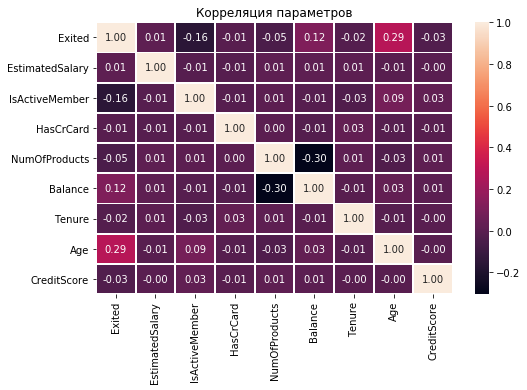

In [21]:
sns.heatmap(data=df[df.columns[ : : -1]].corr(),
    annot=True, fmt='0.2f', linewidths=.8
)
plt.title('Корреляция параметров')
plt.show()

Мультиколлениарности не обнаружено, также не наблюдается значительных зависимостей между параметрами

#### 1.2.2 Построим Скатерплот для каждой пары признаков 

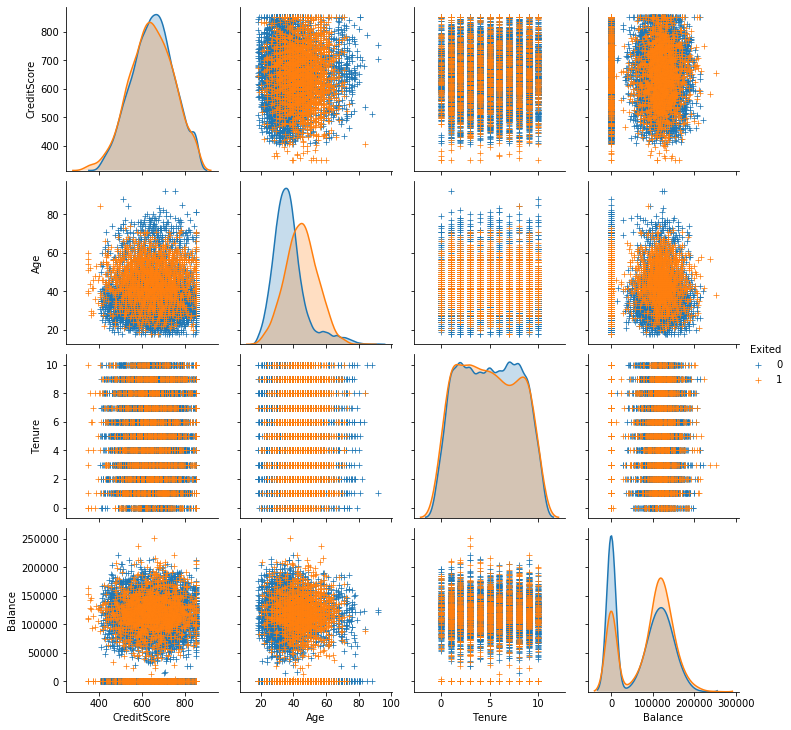

CPU times: user 3.49 s, sys: 21.6 ms, total: 3.52 s
Wall time: 3.52 s


In [22]:
%%time
sns.pairplot(df[np.append(df.columns[: 6], 'Exited')], hue="Exited", markers="+")
plt.show()

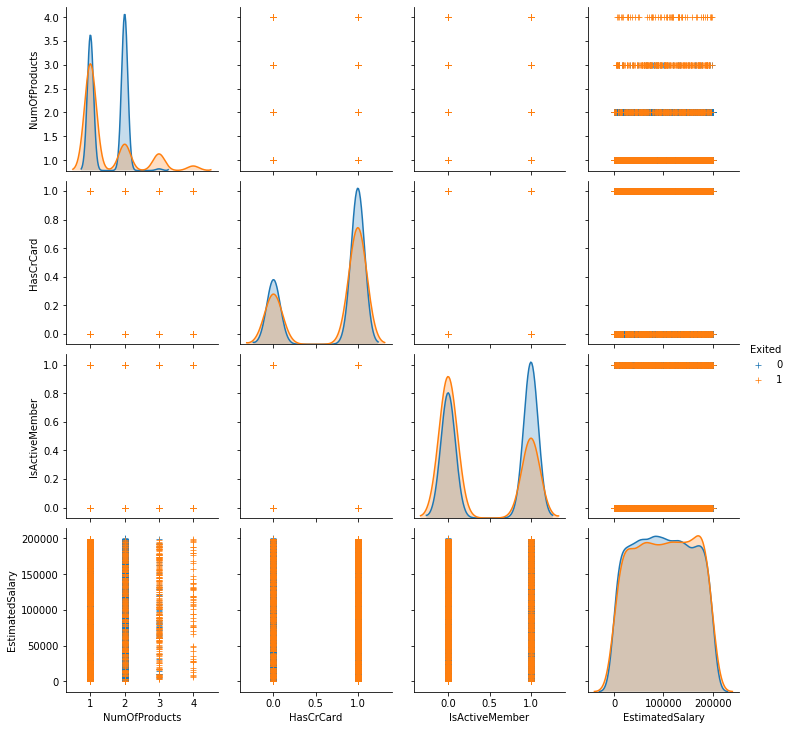

CPU times: user 3.64 s, sys: 21 ms, total: 3.66 s
Wall time: 3.66 s


In [23]:
%%time
sns.pairplot(df[df.columns[ 6: ]], hue="Exited", markers="+")
plt.show()

Очевидно, что клиенты, которые склонны покидать банк, обладают следующими признаками:
+ более молоды;
+ не хранят деньги на счете;
+ пользуются не более чем 2-мя продуктами;
+ при этом большая часть является активными клиентами;
+ имеют кредитные карты.

Также наблюдаются выбросы по признакам `Balance` и `Age` при целевом признаке `Exited = 1`

#### 1.2.3 Удалим выбросы при значении целевого признака

In [24]:
age_exit1_low_board, age_exit1_high_board = find_outlines(df.loc[df['Exited'] == 1, ['Age']])
print('Верхняя граница нормальных значений равна: {:.0f}\nНижняя граница нормальных значений равна: {:.0f}'
      .format(age_exit1_low_board, age_exit1_high_board))

Верхняя граница нормальных значений равна: 18
Нижняя граница нормальных значений равна: 70


In [25]:
age_exit0_low_board, age_exit0_high_board = find_outlines(df.loc[df['Exited'] == 0, ['Age']])
print('Верхняя граница нормальных значений равна: {:.0f}\nНижняя граница нормальных значений равна: {:.0f}'
      .format(age_exit0_low_board, age_exit0_high_board))

Верхняя граница нормальных значений равна: 16
Нижняя граница нормальных значений равна: 56


In [26]:
balance_low_board, balance_high_board = find_outlines(df.loc[df['Exited'] == 1, ['Balance']])
print('Верхняя граница нормальных значений равна: {:.0f}\nНижняя граница нормальных значений равна: {:.0f}'
      .format(balance_low_board, balance_high_board))

Верхняя граница нормальных значений равна: -101300
Нижняя граница нормальных значений равна: 271073


In [27]:
df.loc[(df['Exited'] == 1) , 'Balance'].max() #Выбросов нет

250898.09

In [28]:
len(df.loc[(df['Exited'] == 1) & (df['Age'] > age_exit1_high_board)])

11

In [29]:
print('Вероятность встретить человека, который отказался от услуг банка и при этом старше {:.0f} составляет {:.2%}'
      .format(age_exit1_high_board, len(df.loc[(df['Exited'] == 1) & (df['Age'] > age_exit1_high_board)]) / len(df)))

Вероятность встретить человека, который отказался от услуг банка и при этом старше 70 составляет 0.11%


Исходя из низкой вероятности такого события удалим данные, которые определены как выбросы для признака `Age`

In [30]:
df = df.drop(df.loc[(df['Exited'] == 1) & (df['Age'] > age_exit1_high_board)].index)

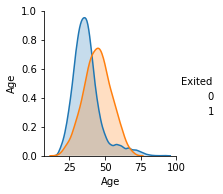

In [31]:
sns.pairplot(df[['Age', 'Exited']], hue="Exited", markers="+")
plt.show()

Для значений с признаком `Exited = 0` также наблюдаются выбросы, но стоит отметить что количество выбросов составляет почти 500 объектв, т.к. удаление такого количества значений может сильно отразиться на качестве модели. Удалять не будем

#### 1.2.4 Проведем анализ целевого признака

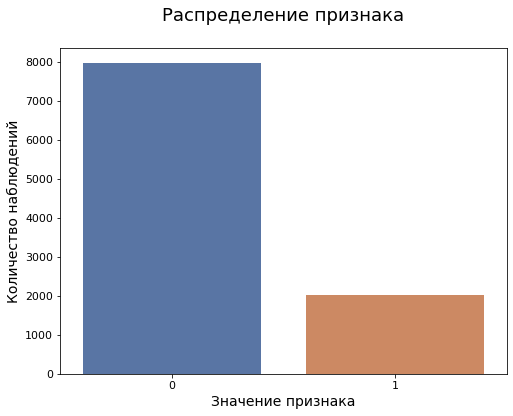

Доля клиентов, прекративших обслуживание: 20%
Наблюдается дисбаланс классов


In [32]:
count_features_plot(df.Exited)
print('Доля клиентов, прекративших обслуживание: {:.0%}'.format(df.Exited.mean()))
if (df.Exited.mean() < .4) | (df.Exited.mean() > .5): print('Наблюдается дисбаланс классов')

### Вывод:

1. Признаки содержат тип данных str, необходимо приведение к бинарной форме
2. Для более качественной оценки зависимостей в ходе работы применим масштабирование признаков
3. Наблюдается дисбаланс целевго признака
4. Мультиколлениарность среди признаков не наблюдается

## 1.3. Подготовим данные для модели (без учета дисбаланса)

### 1.3.1 One-Hot Encoding

In [33]:
df_ohe = pd.get_dummies(df, drop_first=True)

Проверим корреляцию

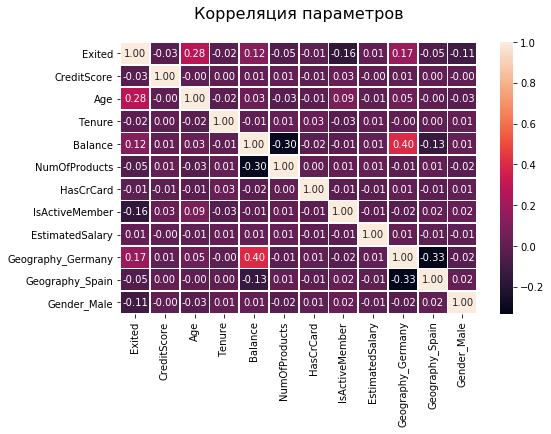

In [34]:
sns.heatmap(data=df_ohe[np.append('Exited', df_ohe.drop(['Exited'], axis=1).columns)].corr(),
    annot=True, fmt='0.2f', linewidths=.8
)
plt.title('Корреляция параметров\n', fontsize=16)
plt.show()

#### 1.3.1.1 Проверим важность признаков

Оценим статистическую важность признака при помощи Т-теста для двух выборок(`Exited=0` и `Exited=1`)

В качестве параметра оценки возьмем показатель степени p-value с противоположным значением - чем больше степень - тем меньше шансов принять Нулевую гипотезу о равенстве выборок, следовательно тем больше разничие по данному признаку

In [35]:
stat_importance = {}
for col in df_ohe.drop(['Exited'], axis=1).columns:
    stat_result = st.ttest_ind(df_ohe.loc[(df_ohe[col].notnull()) & (df.Exited == 1), col],
                               df_ohe.loc[(df_ohe[col].notnull()) & (df.Exited == 0), col],
                               equal_var=False
                              )
    stat_importance[col] = [-1 * np.log10(stat_result.pvalue)]

In [36]:
stat_importance = pd.DataFrame(stat_importance, index=['importance']).T

In [37]:
stat_importance = 1- (stat_importance.max() - stat_importance) / (stat_importance.max() - stat_importance.min())

In [38]:
stat_importance.sort_values(by='importance', ascending=False).style.bar()

,importance
Age,1.000000
IsActiveMember,0.316088
Geography_Germany,0.301200
Balance,0.191850
Gender_Male,0.141396
Geography_Spain,0.041186
NumOfProducts,0.018755
CreditScore,0.009880
Tenure,0.003995
EstimatedSalary,0.001505


Проверим важность признаков при помощи метода `feature_importances_`

In [39]:
print('Важность признаков методом feature_importances_:\n', pd.DataFrame(RandomForestClassifier().
             fit(df_ohe.loc[df_ohe.Tenure.notnull()].drop(['Exited'], axis=1),
                 df_ohe.loc[df_ohe.Tenure.notnull(), 'Exited'])\
             .feature_importances_, index=df_ohe.drop(['Exited'], axis=1)
             .columns
            )\
            .sort_values(by=0, ascending=False))

Важность признаков методом feature_importances_:
                      0
Age               0.24
EstimatedSalary   0.15
CreditScore       0.14
Balance           0.14
NumOfProducts     0.12
Tenure            0.08
IsActiveMember    0.04
Geography_Germany 0.03
Gender_Male       0.02
HasCrCard         0.02
Geography_Spain   0.01


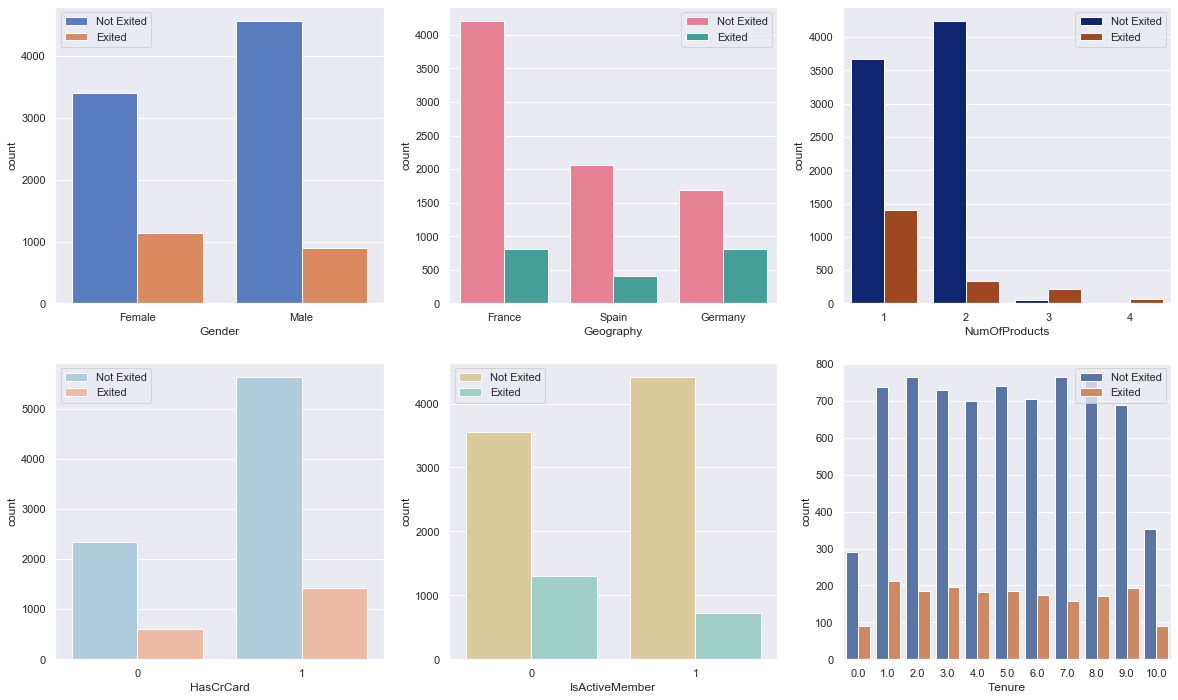

In [40]:
sns.set(color_codes=True)
plt.figure(figsize=(20,12))

A=['Gender','Geography','NumOfProducts','HasCrCard',"IsActiveMember", "Tenure"]
B=["muted","husl","dark","RdBu_r","BrBG", "deep"]

for i in range(len(A)):
    plt.subplot(2,3,i+1)
    sns.countplot(x=A[i], hue='Exited', data=df, palette=B[i])

    plt.xticks(rotation=0)
    plt.legend(["Not Exited", "Exited"])

plt.show()

### 1.3.2 Заполним пропуски для признака `Tenure`

В качестве целевого признака выберем столбец `Tenure`. Тествой выборкой будут являться числа с пропусками, в качестве тренировочной выберем столбцы без пропусков.

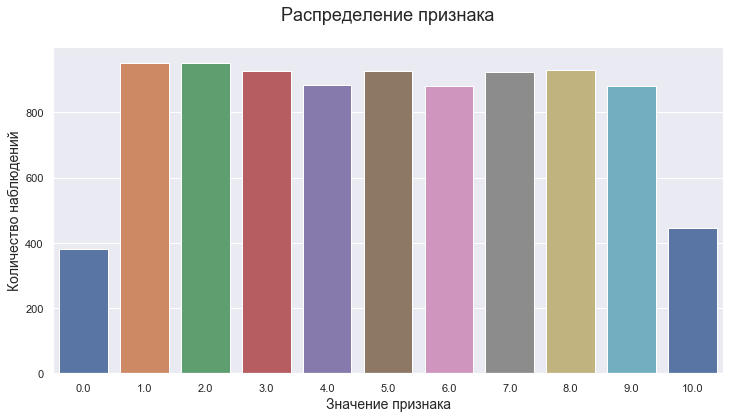

In [41]:
count_features_plot(df.Tenure, plot_width=12)

Исходя из диаграммы можно заменить на среднее значение, тем неменее произведем замену при помощи KNeighborsRegressor

In [42]:
X_Tenure_fillna, y_Tenure_fillna = df_ohe.drop(['Tenure'], axis=1), df_ohe.Tenure

In [43]:
X_Tenure_fillna_train = X_Tenure_fillna.loc[y_Tenure_fillna.notnull()]
y_Tenure_fillna_train = y_Tenure_fillna.loc[y_Tenure_fillna.notnull()]
X_Tenure_fillna_test  = X_Tenure_fillna.loc[y_Tenure_fillna.isnull()]

Произведем мастабирование

In [44]:
numeric_features_for_fillna = [
    'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary'
]

In [45]:
scaler_for_fillna = StandardScaler()

scaler_for_fillna.fit(X_Tenure_fillna_train[numeric_features_for_fillna])

X_Tenure_fillna_train[numeric_features_for_fillna] = (
    scaler_for_fillna\
    .transform(X_Tenure_fillna_train[numeric_features_for_fillna])
)

# Проверим
X_Tenure_fillna_train[numeric_features_for_fillna].describe()['mean': 'std']

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
mean,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00


(Закомментировано диапазон, который проверялся, для быстроты выполнения)

In [46]:
%%time
kNR_param = {
    'n_neighbors' : [1455], #np.arange(5, 2000, 100),
    'weights'     : ['uniform'],#, 'distance'],
    'algorithm'   : ['auto']#, 'ball_tree', 'kd_tree', 'brute'],
}

kNR_for_Tenure = GridSearchCV(KNeighborsRegressor(n_jobs=-1),
                     kNR_param,
                     cv=5
                    )
kNR_for_Tenure.fit(X_Tenure_fillna_train, y_Tenure_fillna_train)

CPU times: user 631 ms, sys: 647 ms, total: 1.28 s
Wall time: 2.25 s


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto'], 'n_neighbors': [1455],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
kNR_for_Tenure.best_score_ #Можно было заменить средним, но тем немение поупражнялись

-0.00022463260600749101

In [48]:
df_ohe.loc[df_ohe.Tenure.isnull(), 'Tenure'] = (
    pd.Series(kNR_for_Tenure.predict(X_Tenure_fillna_test), 
              index=X_Tenure_fillna_test.index
             ).apply(lambda x: round(x))
)

### 1.3.3 Разделим на тренировочную, валидационную и отложенную выборки

Разделим выборки в соотношении 3:1:1
`random_state = 0`

In [49]:
X, y = df_ohe.drop(['Exited'], axis=1), df_ohe['Exited']

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=0)

In [51]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0)

In [52]:
df_for_ml = {
    'Тренировочная' : X_train,
    'Валидационная' : X_valid,
    'Тестовая' : X_test,
    'Таргет тренировочной' : y_train,
    'Таргет валидационной' : y_valid,
    'Таргет тестовой' : y_test,
}
print('Размер выборок:')
for elem in df_for_ml:
    print(elem, ':', df_for_ml.get(elem).shape)

Размер выборок:
Тренировочная : (5993, 11)
Валидационная : (1998, 11)
Тестовая : (1998, 11)
Таргет тренировочной : (5993,)
Таргет валидационной : (1998,)
Таргет тестовой : (1998,)


### 1.3.4 Произведем масштабировани количественных признаков

Выделим количественные признаки

In [53]:
numeric_features = [
    'CreditScore', 'Age', 'Tenure',
    'Balance', 'EstimatedSalary'
]

In [54]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])

In [55]:
# Проверим
X_train[numeric_features].describe()['mean': 'std']

,CreditScore,Age,Tenure,Balance,EstimatedSalary
mean,0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00


In [56]:
X_valid[numeric_features] = scaler.transform(X_valid[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 2. Исследование задачи

Построим 3 модели классификации для предсказания признака оттока клиентов:
1. LogisticRegression
2. DecisionTreeClassifier
3. RandomForestClassifier

Для определения вменяемости модели введем переменную `sanity_check` соответствующую метке наибольшего класса, т.е. 0

In [57]:
result ={
    "model_name" : [],
    "TP" : [],
    "TN" : [],
    "FP" : [],
    "FN" : []
}

## 2.1 LogisticRegression

In [58]:
model_lr, _, _, _ = hiperparam_for_LogReg(X_tr=X_train, y_tr=y_train, X_val=X_valid, y_val=y_valid)


Лучший результат f1_score = 0.33394 при:
C_value = 0.83768


Accuracy : 0.8163
F1 метрика: 0.3339
Sanity check accuracy: 0.8038


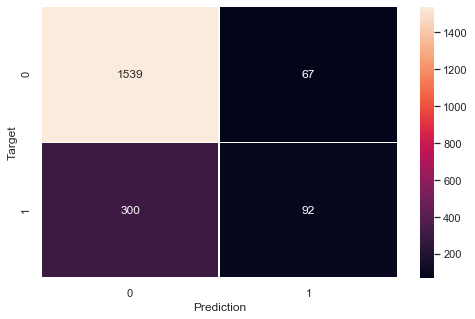

In [59]:
predict_lr, f1_lr, conf_matr_lr = model_fit_and_chek(model_lr,
                                                     X_tr=X_train, y_tr=y_train,
                                                     X_val=X_valid, y_val=y_valid
                                                    )

In [60]:
df_res, result = add_to_result_table('LogisticReg', result, conf_matr_lr)

In [61]:
pd.options.display.float_format = '{:.4f}'.format
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339


Т.к. наблюдается значительный дисбаланс классов, метрика `accuracy_score` не подходит для оценки модели, будем использовать `f1_score`

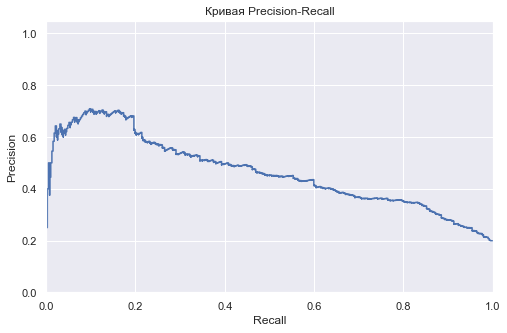

In [62]:
PR_curve_building(model_lr, X_val=X_valid, y_val=y_valid)

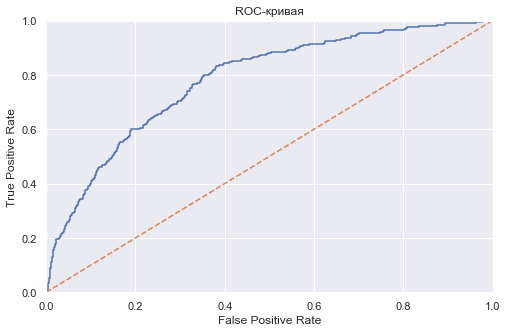

AUC-ROC score: 0.7810


In [63]:
lr_model_prob_valid, lr_model_auc_roc = ROC_curve_building(model_lr, X_val=X_valid, y_val=y_valid)

## 2.2 DecisionTreeClassifier

In [64]:
dtc_params = {
    'max_depth'         : range(3, 25, 3),
    'min_samples_split' : list(range(3, 29, 5)) + list(range(80, 136, 5)),
    'min_samples_leaf'  : range(2, 10),
}

In [65]:
model_dtc, best_score_dtc, _, _ = hiperparam_for_DecTree(dtc_params,
                                                        X_tr=X_train, y_tr=y_train, 
                                                         X_val=X_valid, y_val=y_valid)


Лучший результат f1_score = 0.61601 при:
	max_depth = 18
	min_samples_split = 100
	min_samples_leaf = 2


Accuracy : 0.8584
F1 метрика: 0.6160
Sanity check accuracy: 0.8038


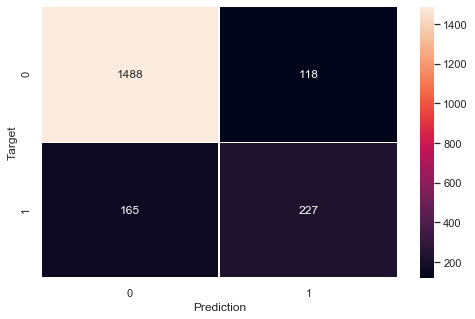

In [66]:
predict_dtc, f1_dtc, conf_matr_dtc = model_fit_and_chek(model_dtc, X_tr=X_train, y_tr=y_train, 
                                                        X_val=X_valid, y_val=y_valid)

In [67]:
df_res, result = add_to_result_table('DecisionTree', result, conf_matr_dtc)

In [68]:
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160


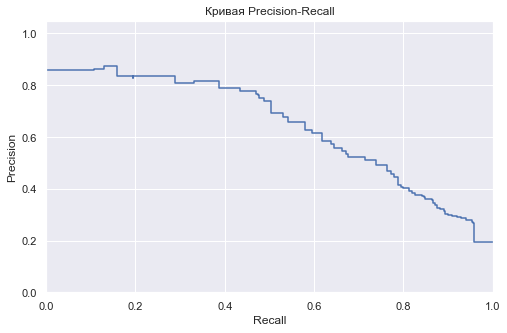

In [69]:
PR_curve_building(model_dtc, X_val=X_valid, y_val=y_valid)

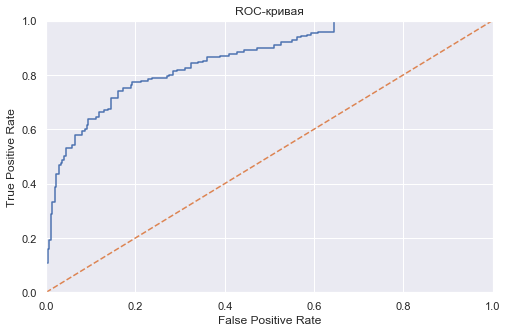

AUC-ROC score: 0.8510


In [70]:
dtc_model_prob_valid, dtc_model_auc_roc = ROC_curve_building(model_dtc,
                                                            X_val=X_valid, y_val=y_valid)

## 2.3 RandomForestClassifier

In [71]:
rfc_param_grid = {
    'n_estimators'      : range(5,10),
    'max_features'      : {'auto'},
    'max_depth'         : range(3, 19, 3),
    'min_samples_leaf'  : range(2, 21, 3),
    'bootstrap'         : (True, False)
}


Лучший результат f1_score = 0.62133 при:
	n_estimators = 7
	max_features = auto
	max_depth = 12
	min_samples_leaf = 14
	bootstrap = True
Accuracy : 0.8774
F1 метрика: 0.6213
Sanity check accuracy: 0.8038


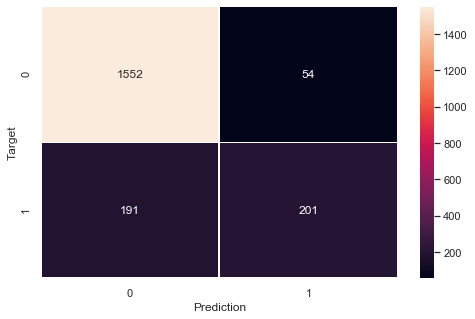

In [72]:
model_rfc, best_score_rfc, _, _ = hiperparam_for_RandForest(rfc_param_grid,
                                                           X_tr=X_train, y_tr=y_train,
                                                            X_val=X_valid, y_val=y_valid)
predict_rfc, f1_rfc, conf_matr_rfc = model_fit_and_chek(model_rfc,
                                                       X_tr=X_train, y_tr=y_train,
                                                        X_val=X_valid, y_val=y_valid)

In [73]:
df_res, result = add_to_result_table('RandomForest', result, conf_matr_rfc)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213


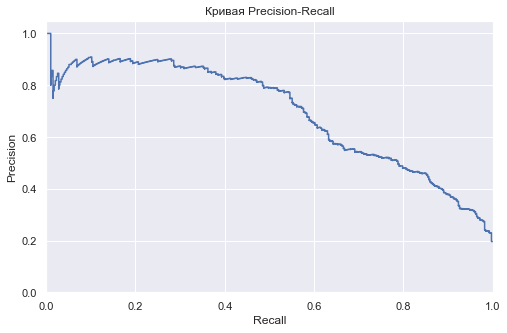

In [74]:
PR_curve_building(model_rfc, X_val=X_valid, y_val=y_valid)

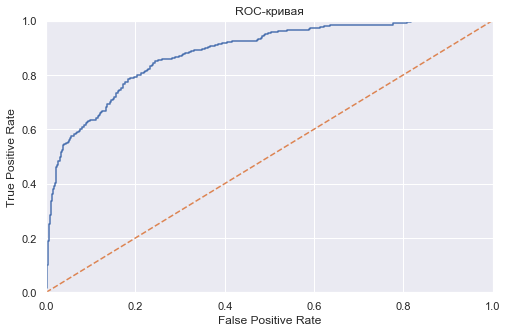

AUC-ROC score: 0.8803


In [75]:
rft_model_prob_valid, rft_model_auc_roc = ROC_curve_building(model_rfc,
                                                            X_val=X_valid, y_val=y_valid)

## Вывод

1. Самое низкое качество показала модель Логистической регрессии, возможно сильно сказывается дисбаланс классов
2. Качество Случайного леса и Дерева решений приблизительно похожи и составляют более f1=0.61 

# 3. Борьба с дисбалансом

Для повышения качества модели изменим баланс классов для тренировочной выборки следующими методами:
1. Upsampling
2. Downsampilng
3. Аргумент class_weight

Проверять будем для 3-х моделях<br/>
Для оценки качества моделей будем использовать метрику F1


## 3.1 Аргумент `class_weight`

### 3.1.1 LogisticRegression

In [76]:
model_lr, lr_model_param, c_value, f1_lr_list = hiperparam_for_LogReg(cl_wigth='balanced',
                                                                     X_tr=X_train, y_tr=y_train, 
                                                                      X_val=X_valid, y_val=y_valid)


Лучший результат f1_score = 0.51932 при:
C_value = 0.00049


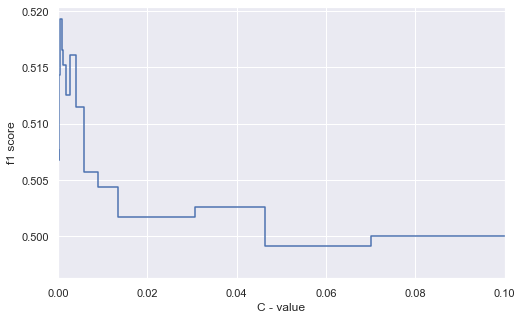

Лучший результат f1 = 0.5193, при С = 0.00049


In [77]:
plt.figure()
plt.step(c_value, f1_lr_list, where='post')
plt.ylabel('f1 score')
plt.xlabel('C - value')
plt.xlim([0.0, 0.1])
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}, при С = {:.5f}'.format(lr_model_param["f1_score"], lr_model_param["c_value"]))

Accuracy : 0.7322
F1 метрика: 0.5193
Sanity check accuracy: 0.8038


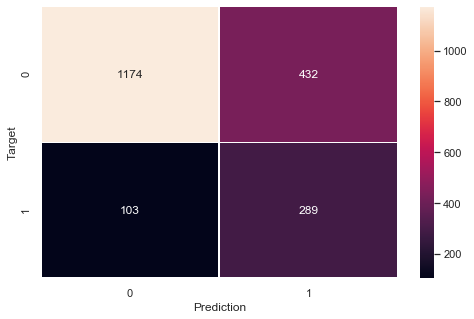

In [78]:
predict_lr, f1_lr, conf_matr_lr = model_fit_and_chek(model_lr,
                                                     X_tr=X_train, y_tr=y_train,
                                                     X_val=X_valid, y_val=y_valid)

In [79]:
df_res, result = add_to_result_table('LogisticReg balanced', result, conf_matr_lr)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193


### 3.1.2 DecisionTreeClassifier

In [80]:
model_dtc, best_score_dtc, iter_number, f1_dtc_class_balanced = (
    hiperparam_for_DecTree(cl_wigth='balanced', param=dtc_params, 
                           X_tr=X_train, y_tr=y_train, 
                           X_val=X_valid, y_val=y_valid)
)


Лучший результат f1_score = 0.60465 при:
	max_depth = 12
	min_samples_split = 110
	min_samples_leaf = 4


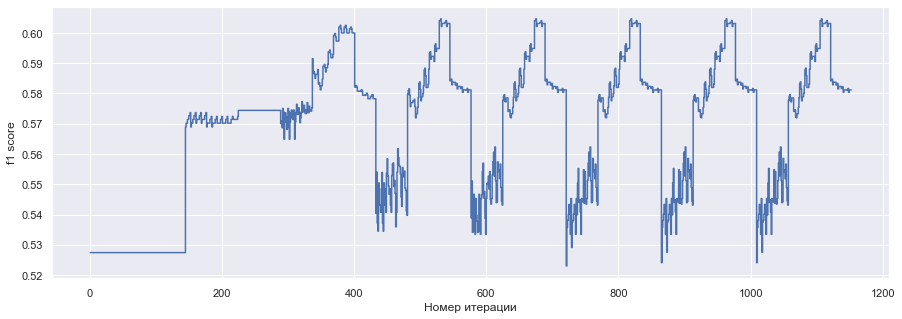

Лучший результат f1 = 0.6047


In [81]:
plt.figure(figsize=(15, 5))
plt.step(iter_number, f1_dtc_class_balanced, where='post')
plt.ylabel('f1 score')
plt.xlabel('Номер итерации')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(best_score_dtc["f1_score"]))

Accuracy : 0.7958
F1 метрика: 0.6047
Sanity check accuracy: 0.8038


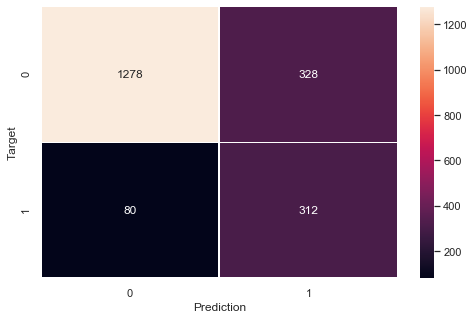

In [82]:
predict_dtc, f1_dtc, conf_matr_dtc = model_fit_and_chek(model_dtc, X_tr=X_train, y_tr=y_train,
                                                        X_val=X_valid, y_val=y_valid)

In [83]:
df_res, result = add_to_result_table('DecisionTree balanced', result, conf_matr_dtc)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047


### 3.1.3 RandomForest

In [84]:
#Комментарием указан диапазон для которого проверяли, оставлен только лучший полученный результат
rfc_param_grid = {
    'n_estimators': range(90, 111, 10), #list(range(4, 12, 2)) + list(range(70, 115, 5)),
    'max_features': {'sqrt', 'auto'}, #{'auto', 'sqrt', 'log2'},
    'max_depth': range(9, 16, 3), #range(3, 19, 3),
    'min_samples_leaf': range(2, 11, 5),#range(2, 21, 3),
    'bootstrap': (True, False)
}

In [85]:
%%time
model_rfc, best_score_rfc, iter_number, f1_rfc_class_balanced = (
    hiperparam_for_RandForest(cl_wigth='balanced', param=rfc_param_grid,
                             X_tr=X_train, y_tr=y_train, 
                              X_val=X_valid, y_val=y_valid)
)


Лучший результат f1_score = 0.64350 при:
	n_estimators = 100
	max_features = sqrt
	max_depth = 12
	min_samples_leaf = 2
	bootstrap = True
CPU times: user 37 s, sys: 225 ms, total: 37.2 s
Wall time: 37.2 s


In [86]:
best_model = model_rfc

In [87]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

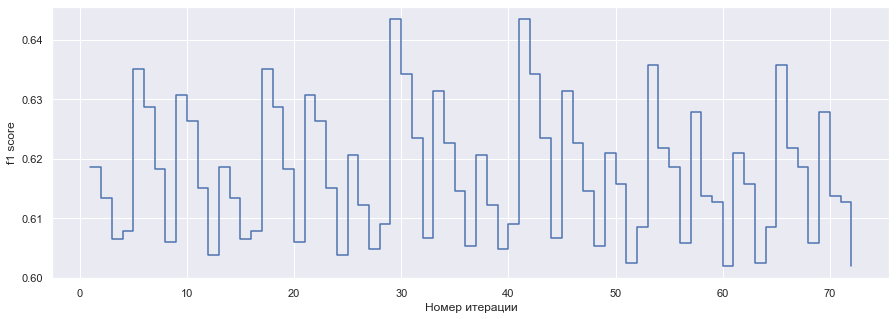

Лучший результат f1 = 0.6435


In [88]:
plt.figure(figsize=(15, 5))
plt.step(iter_number, f1_rfc_class_balanced, where='post')
plt.ylabel('f1 score')
plt.xlabel('Номер итерации')
# plt.xlim([4500,5500])
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(best_score_rfc["f1_score"]))

Accuracy : 0.8614
F1 метрика: 0.6435
Sanity check accuracy: 0.8038


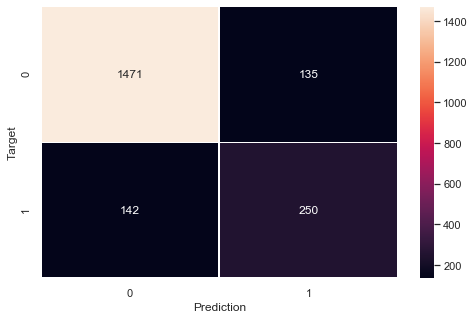

In [89]:
predict_rfc, f1_rfc, conf_matr_rfc = model_fit_and_chek(model_rfc,
                                                        X_tr=X_train, y_tr=y_train,
                                                        X_val=X_valid, y_val=y_valid)

In [90]:
df_res, result = add_to_result_table('RandomForest balanced', result, conf_matr_rfc)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047
5,RandomForest balanced,250,1471,135,142,0.6378,0.6494,0.6435


## 3.2 Upsampling

### 3.2.1 LogisticRegression

In [91]:
lr_model_upsamp_score = {
    "repeat_number" : 0,
    "f1_score" : 0
}
f1_lr_for_plot = []
for repeat_number in range(1, 16):
    X_upsampled, y_upsampled = upsample(X_train, y_train, repeat_number)
    model_lr = LogisticRegression(C=1, random_state=0, solver='liblinear')
    model_lr.fit(X_upsampled, y_upsampled)
    predict_lr = model_lr.predict(X_valid)
    f1_lr = f1_score(y_valid, predict_lr)
    f1_lr_for_plot.append(f1_lr)
    if f1_lr > lr_model_upsamp_score['f1_score']:
        lr_model_upsamp_score['f1_score'] = f1_lr
        lr_model_upsamp_score['repeat_number'] = repeat_number
        

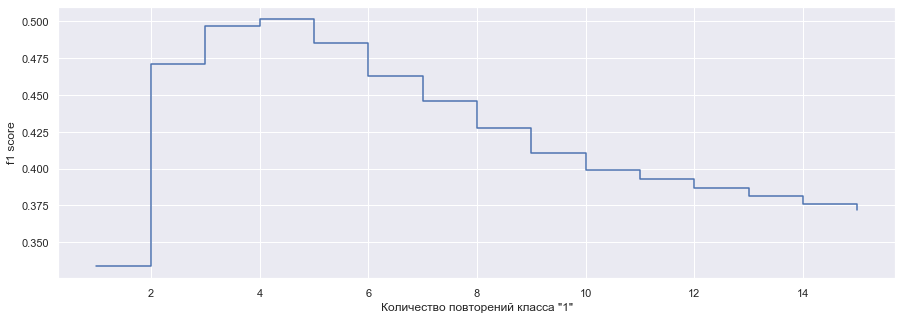

Лучший результат f1 = 0.5017
При количестве повторений: 4


In [92]:
plt.figure(figsize=(15, 5))
plt.step(range(1, 16), f1_lr_for_plot, where='post')
plt.ylabel('f1 score')
plt.xlabel('Количество повторений класса "1"')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(lr_model_upsamp_score['f1_score']))
print('При количестве повторений: {}'.format(lr_model_upsamp_score['repeat_number']))

In [93]:
X_upsampled, y_upsampled = upsample(X_train, y_train, lr_model_upsamp_score['repeat_number'])
model_lr, lr_model_param, _, _  = hiperparam_for_LogReg(X_tr=X_upsampled, y_tr=y_upsampled,
                                                       X_val=X_valid, y_val=y_valid)


Лучший результат f1_score = 0.51224 при:
C_value = 0.00113


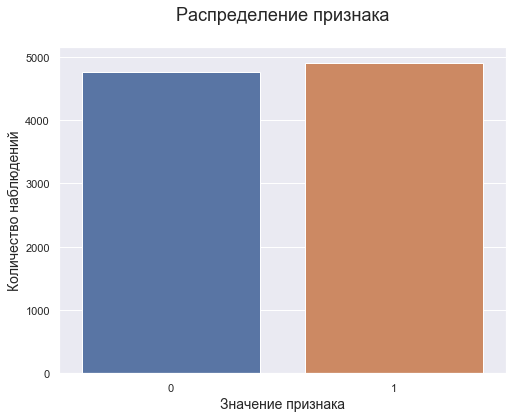

In [94]:
count_features_plot(y_upsampled)

Accuracy : 0.7207
F1 метрика: 0.5122
Sanity check accuracy: 0.8038


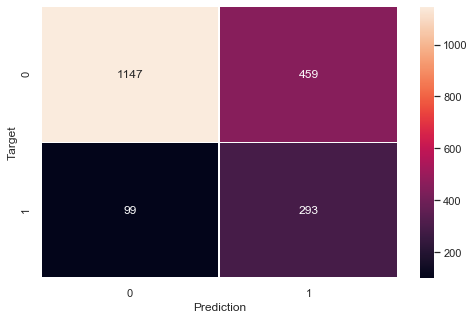

In [95]:
predict_lr, f1_lr, conf_matr_lr = model_fit_and_chek(model_lr, X_tr=X_upsampled, y_tr=y_upsampled,
                                                    X_val=X_valid, y_val=y_valid)

In [96]:
df_res, result = add_to_result_table('LogisticReg upsamp', result, conf_matr_lr)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047
5,RandomForest balanced,250,1471,135,142,0.6378,0.6494,0.6435
6,LogisticReg upsamp,293,1147,459,99,0.7474,0.3896,0.5122


### 3.2.2 DecisionTreeClassifier

In [97]:
dtc_model_upsamp_score = {
    "repeat_number" : 0,
    "f1_score" : 0
}
f1_dtc_for_plot = []
for repeat_number in range(1, 16):
    X_upsampled, y_upsampled = upsample(X_train, y_train, repeat_number)
    model_dtc = DecisionTreeClassifier(max_depth=12, min_samples_split=110, random_state=12345)
    model_dtc.fit(X_upsampled, y_upsampled)
    predict_dtc = model_dtc.predict(X_valid)
    f1_dtc = f1_score(y_valid, predict_dtc)
    f1_dtc_for_plot.append(f1_dtc)
    if f1_dtc > dtc_model_upsamp_score['f1_score']:
        dtc_model_upsamp_score['f1_score'] = f1_dtc
        dtc_model_upsamp_score['repeat_number'] = repeat_number
        

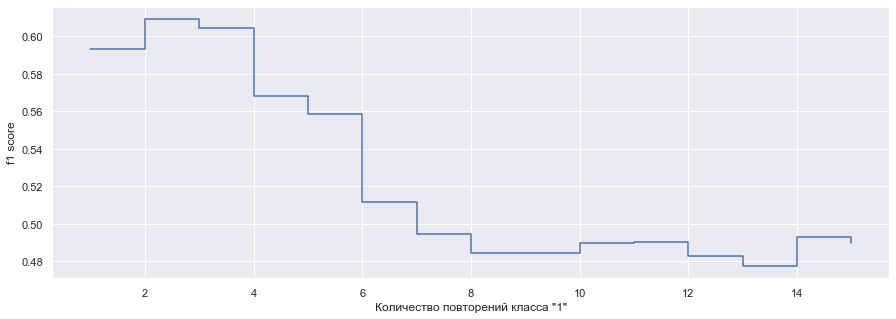

Лучший результат f1 = 0.6093
При количестве повторений: 2


In [98]:
plt.figure(figsize=(15, 5))
plt.step(range(1, 16), f1_dtc_for_plot, where='post')
plt.ylabel('f1 score')
plt.xlabel('Количество повторений класса "1"')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(dtc_model_upsamp_score['f1_score']))
print('При количестве повторений: {}'.format(dtc_model_upsamp_score['repeat_number']))

In [99]:
X_upsampled, y_upsampled = upsample(X_train, y_train, dtc_model_upsamp_score['repeat_number'])

model_dtc, best_score_dtc, _, _ = (
    hiperparam_for_DecTree(X_tr=X_upsampled, y_tr=y_upsampled, param=dtc_params,
                          X_val=X_valid, y_val=y_valid)
)


Лучший результат f1_score = 0.62200 при:
	max_depth = 12
	min_samples_split = 115
	min_samples_leaf = 5


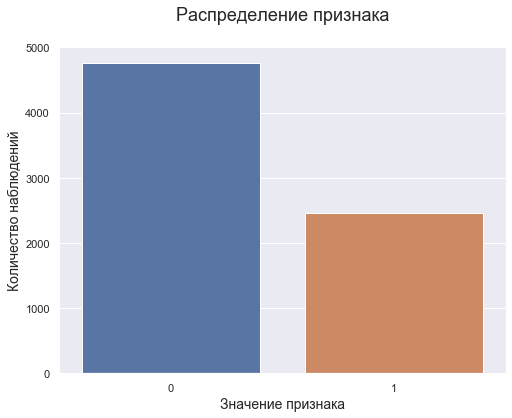

In [100]:
count_features_plot(y_upsampled)

Accuracy : 0.8504
F1 метрика: 0.6220
Sanity check accuracy: 0.8038


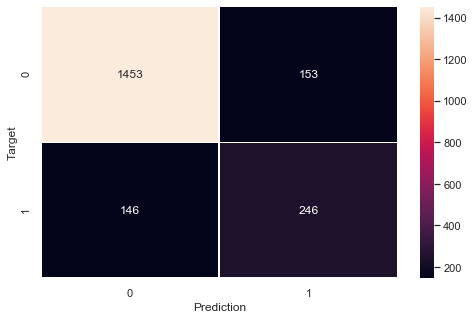

In [101]:
predict_dtc, f1_dtc, conf_matr_dtc = model_fit_and_chek(model_dtc, X_tr=X_upsampled, y_tr=y_upsampled,
                                                       X_val=X_valid, y_val=y_valid)

In [102]:
df_res, result = add_to_result_table('DecisionTree upsamp', result, conf_matr_dtc)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047
5,RandomForest balanced,250,1471,135,142,0.6378,0.6494,0.6435
6,LogisticReg upsamp,293,1147,459,99,0.7474,0.3896,0.5122
7,DecisionTree upsamp,246,1453,153,146,0.6276,0.6165,0.6220


### 3.2.3 RandomForestClassifier

In [103]:
rfc_param_grid = {
    'n_estimators': range(90,91),
    'max_features': {'auto'},
    'max_depth': range(16, 17),
    'min_samples_leaf': range(2, 3),
    'bootstrap': (True, False)
}

In [104]:
rfc_model_upsamp_score = {
    "repeat_number" : 0,
    "f1_score" : 0
}
f1_rfc_for_plot = []
for repeat_number in range(1, 16):
    X_upsampled, y_upsampled = upsample(X_train, y_train, repeat_number)
    model_rfc = RandomForestClassifier(max_depth=12, n_estimators=100, random_state=12345)
    model_rfc.fit(X_upsampled, y_upsampled)
    predict_rfc = model_dtc.predict(X_valid)
    f1_rfc = f1_score(y_valid, predict_rfc)
    f1_rfc_for_plot.append(f1_rfc)
    if f1_rfc > rfc_model_upsamp_score['f1_score']:
        rfc_model_upsamp_score['f1_score'] = f1_rfc
        rfc_model_upsamp_score['repeat_number'] = repeat_number
        

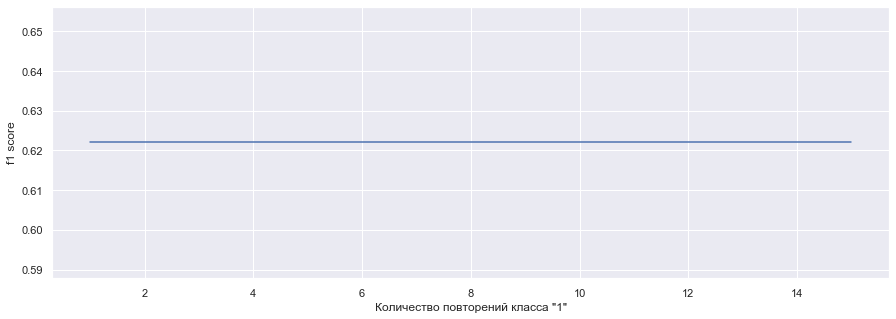

Лучший результат f1 = 0.6220
При количестве повторений: 1


In [105]:
plt.figure(figsize=(15, 5))
plt.step(range(1, 16), f1_rfc_for_plot, where='post')
plt.ylabel('f1 score')
plt.xlabel('Количество повторений класса "1"')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(rfc_model_upsamp_score['f1_score']))
print('При количестве повторений: {}'.format(rfc_model_upsamp_score['repeat_number']))

## 3.3 Downsampling

### 3.3.1 LogisticRegression

In [106]:
lr_model_downsamp_score = {
    "fraction_number" : 0,
    "f1_score" : 0
}
f1_lr_for_plot = []
for fraction_number in np.arange(.05, 0.81, .05):
    X_downsampled, y_downsampled = downsample(X_train, y_train, fraction_number)
    model_lr = LogisticRegression(C=1, random_state=0, solver='liblinear')
    model_lr.fit(X_downsampled, y_downsampled)
    predict_lr = model_lr.predict(X_valid)
    f1_lr = f1_score(y_valid, predict_lr)
    f1_lr_for_plot.append(f1_lr)
    if f1_lr > lr_model_downsamp_score['f1_score']:
        lr_model_downsamp_score['f1_score'] = f1_lr
        lr_model_downsamp_score['fraction_number'] = fraction_number
        

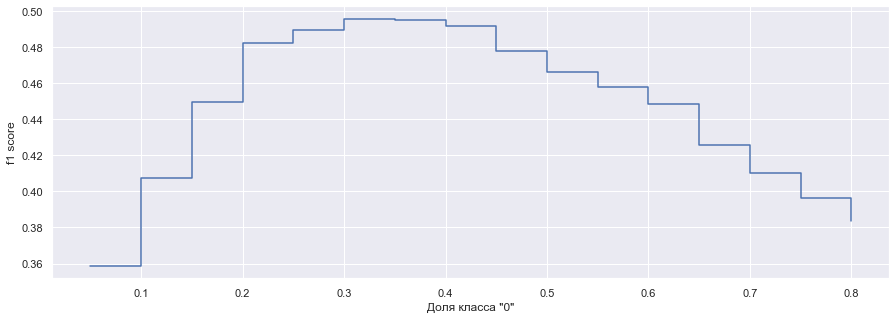

Лучший результат f1 = 0.4958
При доле деления: 0.3


In [107]:
plt.figure(figsize=(15, 5))
plt.step(np.arange(.05, 0.81, .05), f1_lr_for_plot, where='post')
plt.ylabel('f1 score')
plt.xlabel('Доля класса "0"')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(lr_model_downsamp_score['f1_score']))
print('При доле деления: {}'.format(lr_model_downsamp_score['fraction_number']))

In [108]:
X_downsampled, y_downsampled = downsample(X_train, y_train, lr_model_downsamp_score['fraction_number'])
model_lr, lr_model_param, _, _  = hiperparam_for_LogReg(X_tr=X_downsampled, y_tr=y_downsampled,
                                                       X_val=X_valid, y_val=y_valid)


Лучший результат f1_score = 0.50872 при:
C_value = 0.00389


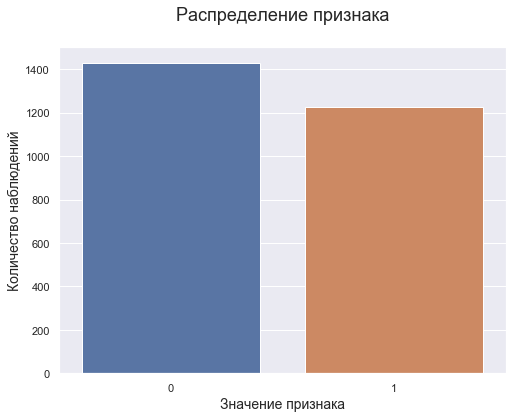

In [109]:
count_features_plot(y_downsampled)

Accuracy : 0.7603
F1 метрика: 0.5087
Sanity check accuracy: 0.8038


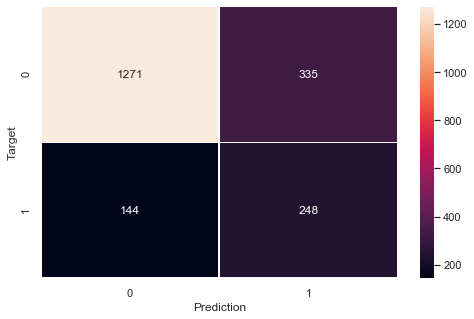

In [110]:
predict_lr, f1_lr, conf_matr_lr = model_fit_and_chek(model_lr, X_tr=X_downsampled, y_tr=y_downsampled,
                                                    X_val=X_valid, y_val=y_valid)

In [111]:
df_res, result = add_to_result_table('LogisticReg downsamp', result, conf_matr_lr)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047
5,RandomForest balanced,250,1471,135,142,0.6378,0.6494,0.6435
6,LogisticReg upsamp,293,1147,459,99,0.7474,0.3896,0.5122
7,DecisionTree upsamp,246,1453,153,146,0.6276,0.6165,0.6220
8,LogisticReg downsamp,248,1271,335,144,0.6327,0.4254,0.5087


### 3.3.2 DecisionTreeClassifier

In [112]:
dtc_model_downsamp_score = {
    "fraction_number" : 0,
    "f1_score" : 0
}
f1_dtc_for_plot = []
for fraction_number in np.arange(.05, 0.81, .05):
    X_downsampled, y_downsampled = downsample(X_train, y_train, fraction_number)
    model_dtc = DecisionTreeClassifier(max_depth=12, min_samples_split=110, random_state=12345)
    model_dtc.fit(X_downsampled, y_downsampled)
    predict_dtc = model_dtc.predict(X_valid)
    f1_dtc = f1_score(y_valid, predict_dtc)
    f1_dtc_for_plot.append(f1_dtc)
    if f1_dtc > dtc_model_downsamp_score['f1_score']:
        dtc_model_downsamp_score['f1_score'] = f1_dtc
        dtc_model_downsamp_score['fraction_number'] = fraction_number
        

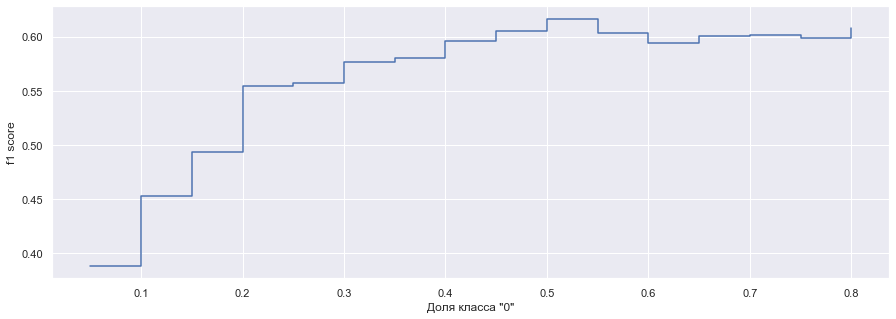

Лучший результат f1 = 0.6165
При доле деления: 0.5


In [113]:
plt.figure(figsize=(15, 5))
plt.step(np.arange(.05, 0.81, .05), f1_dtc_for_plot, where='post')
plt.ylabel('f1 score')
plt.xlabel('Доля класса "0"')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(dtc_model_downsamp_score['f1_score']))
print('При доле деления: {}'.format(dtc_model_downsamp_score['fraction_number']))

In [114]:
X_downsampled, y_downsampled = downsample(X_train, y_train, dtc_model_downsamp_score['fraction_number'])

model_dtc, best_score_dtc, _, _ = (
    hiperparam_for_DecTree(X_tr=X_downsampled, y_tr=y_downsampled, param=dtc_params,
                          X_val=X_valid, y_val=y_valid)
)


Лучший результат f1_score = 0.61937 при:
	max_depth = 9
	min_samples_split = 85
	min_samples_leaf = 3


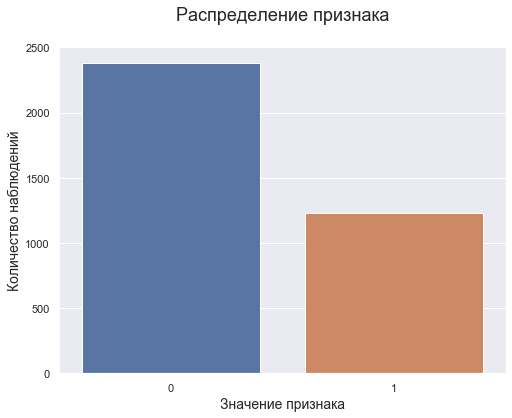

In [115]:
count_features_plot(y_downsampled)

Accuracy : 0.8308
F1 метрика: 0.6194
Sanity check accuracy: 0.8038


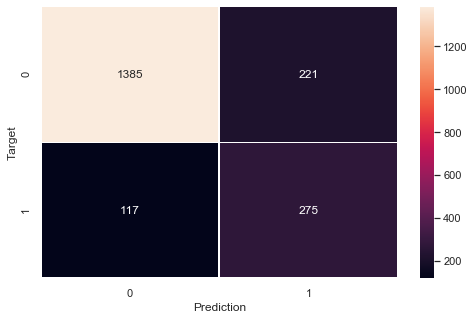

In [116]:
predict_dtc, f1_dtc, conf_matr_dtc = model_fit_and_chek(model_dtc, X_tr=X_downsampled, y_tr=y_downsampled,
                                                       X_val=X_valid, y_val=y_valid)

In [117]:
df_res, result = add_to_result_table('DecisionTree downsamp', result, conf_matr_dtc)
df_res

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047
5,RandomForest balanced,250,1471,135,142,0.6378,0.6494,0.6435
6,LogisticReg upsamp,293,1147,459,99,0.7474,0.3896,0.5122
7,DecisionTree upsamp,246,1453,153,146,0.6276,0.6165,0.6220
8,LogisticReg downsamp,248,1271,335,144,0.6327,0.4254,0.5087
9,DecisionTree downsamp,275,1385,221,117,0.7015,0.5544,0.6194


### 3.2.3 RandomForestClassifier

In [118]:
rfc_param_grid = {
    'n_estimators': range(90,91),
    'max_features': {'auto'},
    'max_depth': range(16, 17),
    'min_samples_leaf': range(2, 3),
    'bootstrap': (True, False)
}

In [119]:
rfc_model_downsamp_score = {
    "fraction_number" : 0,
    "f1_score" : 0
}
f1_rfc_for_plot = []
for fraction_number in np.arange(.05, 0.81, .05):
    X_downsampled, y_downsampled = downsample(X_train, y_train, fraction_number)
    model_rfc = RandomForestClassifier(max_depth=12, n_estimators=100, random_state=12345)
    model_rfc.fit(X_downsampled, y_downsampled)
    predict_rfc = model_dtc.predict(X_valid)
    f1_rfc = f1_score(y_valid, predict_rfc)
    f1_rfc_for_plot.append(f1_rfc)
    if f1_rfc > rfc_model_downsamp_score['f1_score']:
        rfc_model_downsamp_score['f1_score'] = f1_rfc
        rfc_model_downsamp_score['repeat_number'] = fraction_number
        

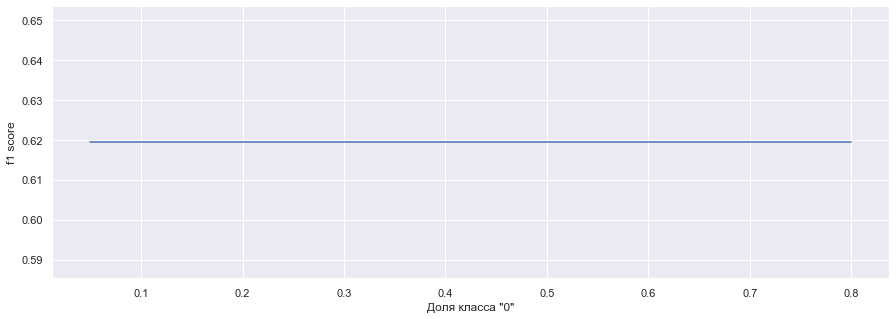

Лучший результат f1 = 0.6194
При доле деления: 0


In [120]:
plt.figure(figsize=(15, 5))
plt.step(np.arange(.05, 0.81, .05), f1_rfc_for_plot, where='post')
plt.ylabel('f1 score')
plt.xlabel('Доля класса "0"')
plt.title('')
plt.show()
print('Лучший результат f1 = {:.4f}'.format(rfc_model_downsamp_score['f1_score']))
print('При доле деления: {}'.format(rfc_model_downsamp_score['fraction_number']))

In [121]:
df_res.sort_values(by='F1_score', ascending=False)

,model_name,TP,TN,FP,FN,Recall,Percision,F1_score
5,RandomForest balanced,250,1471,135,142,0.6378,0.6494,0.6435
7,DecisionTree upsamp,246,1453,153,146,0.6276,0.6165,0.6220
2,RandomForest,201,1552,54,191,0.5128,0.7882,0.6213
9,DecisionTree downsamp,275,1385,221,117,0.7015,0.5544,0.6194
1,DecisionTree,227,1488,118,165,0.5791,0.6580,0.6160
4,DecisionTree balanced,312,1278,328,80,0.7959,0.4875,0.6047
3,LogisticReg balanced,289,1174,432,103,0.7372,0.4008,0.5193
6,LogisticReg upsamp,293,1147,459,99,0.7474,0.3896,0.5122
8,LogisticReg downsamp,248,1271,335,144,0.6327,0.4254,0.5087
0,LogisticReg,92,1539,67,300,0.2347,0.5786,0.3339


## 3.4 Обучим лучшую полученную модель

В качестве лучшей модели принимаем Случайный лес с использованием аргумента `class_weigth`

Обучение произведем на совмещенной выборке train+valid, для этого вновь произведем разделение и масштабирование выбоки

### 3.4.1 Совместим выборки train и valid и произведем масштабирование

In [122]:
X_new_train = pd.concat([X_train] + [X_valid])
y_new_train = pd.concat([y_train] + [y_valid])
    
X_new_train, y_new_train = shuffle(
    X_new_train, y_new_train, random_state=12345
)
    

In [123]:
scaler.fit(X_new_train[numeric_features])
X_new_train[numeric_features] = scaler.transform(X_new_train[numeric_features])

In [124]:
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

### 3.4.2 Обучим модель

In [125]:
best_model.fit(X_new_train, y_new_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

## Вывод

1. Наилучший результат показала модель Случайного леса c использованием аргумента `class_weigth='balanced'`
2. Незначительно удалось улучшить модель Дерева решений при помощи увеличения и уменьшения целевой выборки, использование аргумента `class_weigth='balanced'` привело к снижению качества
3. Наибольшее приращение в качестве показала Логистическая регрессия при использовании методов по борьбе с дисбалансом.
4. В качестве лучшей модели будем использовать Случайный лес с аргументом `class_weigth='balanced'`, обученный на совмещенной выбоке (train+valid) проверим его далее на отложенной выборке

# 4. Тестирование модели

In [126]:
prediction_best = best_model.predict(X_test)
f1_score_best = f1_score(y_test, prediction_best)

In [127]:
f1_score_best

0.6219512195121952

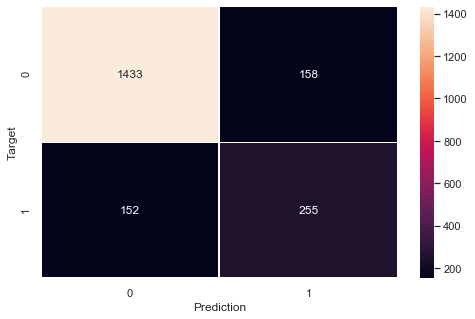

In [128]:
sns.heatmap(confusion_matrix(y_test, prediction_best), annot=True, fmt='d', linewidths=.8)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.show()

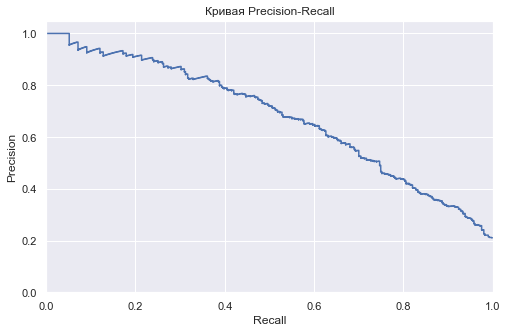

In [129]:
PR_curve_building(best_model, X_val=X_test, y_val=y_test)

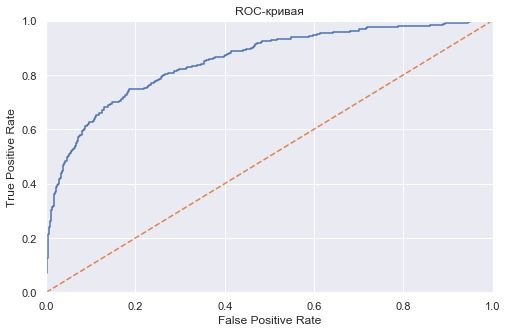

AUC-ROC score: 0.8531


In [130]:
_ = ROC_curve_building(best_model, X_val=X_test, y_val=y_test)

## Вывод

1. Модель значительно лучше случайной AUC-ROC score равен 0.8531
2. F1-мера составила 0.62, что удовлетворяет заданию работы